## Notebook for semantic segmentation of land cover
- Use (12.5cm currently) aerial images (3 bands)
- Use raster masks with class labels
- Use U-net (like) CNN to perform semantic segmentation. 

Thoughts:
- Handle no-class? (class = 0). Could fix in data by interpolating - although that takes some time.. Can we somehow set the cost to 0 of these pixels? Don't want to ruin the conv filters. 
- Possibly change class labels here. (Eg wood vs grass vs other). Probably best to do here when loading raster masks, instead of creating masks like this directly (as they take up considerable disk space and there might be many version. Should be quick to do.)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch, torchvision, torchsummary
import segmentation_models_pytorch as smp

### Split image into patches:

In [3]:
all_patches_img, all_patches_mask = lca.create_all_patches_from_dir(patch_size=512)

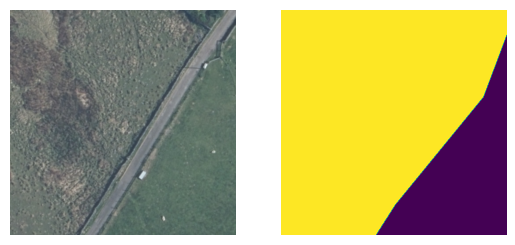

In [4]:
fig, ax = plt.subplots(1, 2)
i_p = 0  # index of patch. Left to righ, top to bottom 
lcv.plot_image_simple(im=all_patches_img[i_p, :, :, :], ax=ax[0])

ax[1].imshow(all_patches_mask[i_p, :, :])
lcv.naked(ax[1])

### Create train/test split
- Random split for now. 
- Later look into way to split classes evenly across train and test set. 

In [46]:
im_train, im_test, mask_train, mask_test = lca.split_patches_in_train_test(all_patches_img=all_patches_img, all_patches_mask=all_patches_mask)

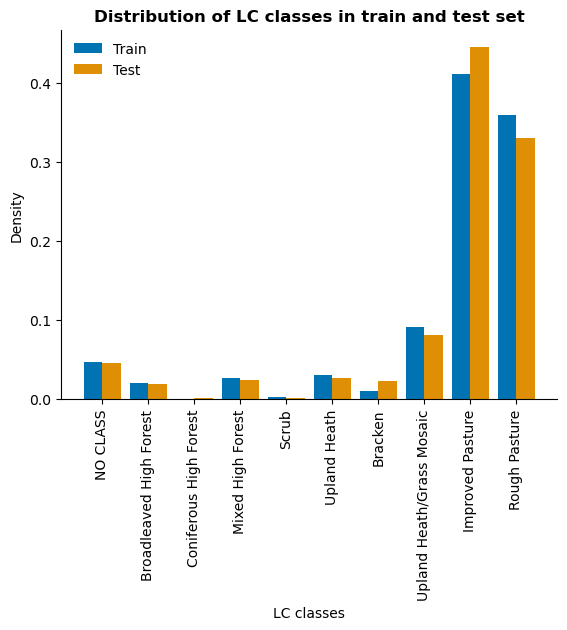

In [25]:
_, __, (names_classes, n_classes) = lcv.plot_comparison_class_balance_train_test(train_patches_mask=mask_train, test_patches_mask=mask_test)

In [47]:
mask_train, mask_test = lca.change_data_to_tensor(mask_train, mask_test, tensor_dtype='int')
im_train, im_test = lca.change_data_to_tensor(im_train, im_test, tensor_dtype='float')

# train_dl, test_dl = lca.create_data_loaders(x_train=im_train, x_test=im_test, y_train=mask_train, y_test=mask_test, batch_size=2)

### Fetch CNN model:
- Resource 1: UNet (https://github.com/milesial/Pytorch-UNet)
- Resource 2: Pytorch pretrained (only Resnet): https://pytorch.org/vision/stable/models.html and https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html (https://debuggercafe.com/semantic-segmentation-using-pytorch-fcn-resnet/)
- Resource 3: SM pretrained: https://github.com/qubvel/segmentation_models.pytorch
- Resource 4: https://medium.com/@mhamdaan/multi-class-semantic-segmentation-with-u-net-pytorch-ee81a66bba89 and https://github.com/hamdaan19/UNet-Multiclass


#### Prep
- See if GPU works:

In [8]:
lca.check_torch_ready()

Pytorch version is 1.12.1+cu102
Torchvision version is 0.13.1+cu102
Segmentation-models-pytorch version is 0.3.0


#### Resource 1 (torch hub):
- Odd output format (2 classes). Not sure how to fix this, perhaps model is not flexible enough to be adapted for our analysis.

In [31]:
unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)

Using cache found in /home/tplas/.cache/torch/hub/milesial_Pytorch-UNet_master


#### Resource 2 (torchvision models):
- No UNet available. 

In [32]:
resnet = torchvision.models.resnet50(weights='IMAGENET1K_V2')  # use pretrained weights, see docs
# res_weights = resnet.parameters

#### Resource 3 (SMP):

In [51]:
n_input_bands = im_train.shape[1]
# n_classes = len(np.unique(mask_test))  # already defined by return of histogram (takes few seconds to compute)

unet_sm = smp.Unet(encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                   encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization or None
                   in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                   classes=n_classes,                      # model output channels (number of classes in your dataset)
                   activation='softmax')  # activation function to apply after final convolution; One of [sigmoid, softmax, logsoftmax, identity, callable, None]

In [49]:
preprocessing_func = smp.encoders.get_preprocessing_fn('resnet50', pretrained='imagenet')
im_train = lca.apply_zscore_preprocess_images(im_ds=im_train, f_preprocess=preprocessing_func, verbose=1)
im_test = lca.apply_zscore_preprocess_images(im_ds=im_test, f_preprocess=preprocessing_func, verbose=1)

train_dl, test_dl = lca.create_data_loaders(x_train=im_train, x_test=im_test, y_train=mask_train, y_test=mask_test, batch_size=2)

torch.float32
Changing range
2 torch.float32
Z scoring data
3 torch.float32
torch.float32
Changing range
2 torch.float32
Z scoring data
3 torch.float32
torch.float32


### Use model:

In [52]:
curr_model = unet_sm

In [58]:
# torchsummary.summary(curr_model, input_size=np.shape(np.squeeze(im_test[0, :, :, :])), device='cpu')

In [30]:
criterion = nn.CrossEntropyLoss()  # see SMP for better loss functions (multiclass types)
optimizer = optim.SGD(curr_model.parameters(), lr=0.001, momentum=0.9)

for it, data in enumerate(train_dl, 0):
    ## it: iteration, data is list of [train_ds, test_ds]
    # print(it, data[1].shape)
    pass 

print(data[0].shape)

In [56]:
tmp = curr_model(data[0])

In [34]:
lca.print_info_ds(data[0])
lca.print_info_ds(data[1])
lca.print_info_ds(tmp)

torch.float32 of shape torch.Size([2, 3, 512, 512])
torch.int64 of shape torch.Size([2, 512, 512])
torch.float32 of shape torch.Size([2, 10, 512, 512])


In [35]:
criterion(tmp, data[1])

IndexError: Target 19 is out of bounds.

In [36]:
i1 = 310 
i2 = 320

print(data[1][0, i1, i2], tmp[0, :, i1, i2])

tensor(19) tensor([0.1462, 0.0977, 0.0213, 0.1382, 0.0826, 0.0412, 0.2335, 0.0493, 0.1164,
        0.0735], grad_fn=<SelectBackward0>)
